In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback

torch.cuda.set_device(1) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df

/home/asalimi/miniconda3/envs/ddsp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/WFDB_CPSC2018.csv")
codes =  pd.read_csv("data/codes.csv",sep=";")
# df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
np.sum(codes["SNOMED CT Code"] == int(df.columns[0]))

1

In [3]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

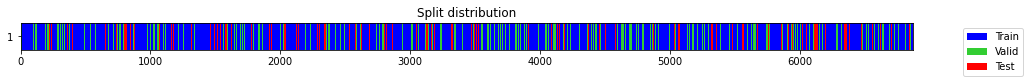

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [4]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [5]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [ ]:
def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len,nf=nf, fc_dropout=dropout_rate, depth=depth)
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "mini" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize')

study.optimize(objective, n_trials=100)

epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.674556,0.666342,0.217712,0.852563,0.585684,0.346739,01:35
1,0.659372,0.649711,0.226437,0.874264,0.596153,0.359569,01:39
2,0.646828,0.639527,0.233429,0.887723,0.605869,0.369533,01:40
3,0.637312,0.631499,0.238902,0.893682,0.614858,0.376890,01:40
4,0.629859,0.623120,0.249548,0.903880,0.632467,0.390984,01:41


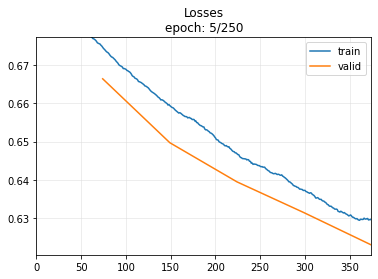

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = MiniRocketPlus(dls.vars, dls.c,2500)
# model = InceptionTimePlus(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

In [22]:
# nn.BCEWithLogitsLoss?

In [23]:
np.array(model(next(iter(dls.train))[0]).detach().cpu())

array([[-7.84720704e-02, -4.12600696e-01, -2.18182340e-01,
        -9.80459303e-02,  3.71059179e-01,  3.25657755e-01,
        -2.48570561e-01,  2.40334675e-01, -1.63715184e-01],
       [ 1.24575153e-01, -1.36219069e-01, -2.46257503e-02,
         1.44775674e-01, -2.14409769e-01,  3.34912658e-01,
         6.78366944e-02,  1.02839664e-01, -1.57196477e-01],
       [ 1.08623877e-01, -2.17653006e-01, -6.15041144e-02,
        -5.97859547e-02, -1.75389633e-01,  1.03842862e-01,
         2.99280167e-01,  3.14129218e-02,  1.27586991e-01],
       [ 4.45486456e-02,  1.15933612e-01, -1.94757894e-01,
         1.51232677e-02, -1.32961482e-01, -1.46226197e-01,
         1.94128394e-01, -1.00214943e-01,  1.58320934e-01],
       [ 7.91124776e-02,  1.14165002e-03,  9.09411684e-02,
         2.47980338e-02, -3.38582963e-01, -7.88431522e-03,
         2.37779394e-01, -1.16928264e-01,  1.32603616e-01],
       [-6.40033036e-02,  6.39755726e-01, -1.48044795e-01,
         1.43291265e-01,  3.59730870e-01, -6.117059

In [9]:
TSTnext(iter(dls.train))[1]

NameError: name 'TSTnext' is not defined